In [67]:
# A pipeline to walk through stuff 
from alphazero.games.othello import OthelloBoard, OthelloNet
from alphazero.players import AlphaZeroPlayer, MCTSPlayer

In [68]:
board_size = 8 
board = OthelloBoard(n=board_size)

In [69]:
name = 'alphazero-othello-8'
checkpoint = 'models/'
net = OthelloNet.from_pretrained(name, checkpoint)
player = AlphaZeroPlayer(nn=net, n_sim=10000)

In [70]:
board_snapshot = board.clone()

In [71]:
# Step 2: Run MCTS on the board (this fills the tree)
move, action_probs, visit_counts, prior_probs = player.get_move(board)
mct = player.mct

print(f"Root had {len(mct.root.children)} children. Best move chosen: {move}")
print(f"Visit counts at root: {visit_counts}")

Root had 4 children. Best move chosen: (2, 4)
Visit counts at root: {(4, 2): 1769, (5, 3): 2183, (2, 4): 3144, (3, 5): 2904}


In [72]:
# Step 3: Walk down the tree — at each step note best move (chosen) and second-best (disregarded)
def get_decision_path(mct, board=None, max_depth=None, sort_key="N"):
    """Walk from root along most-visited path; at each step return best and second-best move."""
    node = mct.root
    path = []
    depth = 0
    board_copy = board.clone() if board is not None else None

    while node is not None:
        if max_depth is not None and depth >= max_depth:
            break
        step = {"depth": depth}
        if board_copy is not None:
            step["grid"] = board_copy.grid.copy()
            step["player"] = board_copy.player

        if not node.children:
            break

        # Sort children by visit count (or Q) descending
        items = list(node.children.items())
        items.sort(key=lambda x: getattr(x[1], sort_key), reverse=True)

        best_move, best_node = items[0]
        step["best_move"] = best_move
        step["best_N"] = best_node.N
        step["best_Q"] = best_node.Q
        step["best_P"] = best_node.P

        if len(items) >= 2:
            second_move, second_node = items[1]
            step["second_best_move"] = second_move
            step["second_best_N"] = second_node.N
            step["second_best_Q"] = second_node.Q
            step["second_best_P"] = second_node.P
        else:
            step["second_best_move"] = None
            step["second_best_N"] = step["second_best_Q"] = step["second_best_P"] = None

        step["n_children"] = len(node.children)
        path.append(step)
        if board_copy is not None and best_move is not None:
            board_copy.play_move(best_move)
        node = best_node
        depth += 1

    return path

decisions = get_decision_path(mct, board=board_snapshot)

In [73]:
# Step 4: Inspect decisions at each timestep
for step in decisions:
    d = step["depth"]
    best = step["best_move"]
    best_N, best_Q = step["best_N"], step["best_Q"]
    second = step.get("second_best_move")
    second_N = step.get("second_best_N")
    second_Q = step.get("second_best_Q")
    s_N = f"N={second_N:.0f}" if second_N is not None else "N=—"
    s_Q = f"Q={second_Q:.3f}" if second_Q is not None else "Q=—"
    print(f"depth {d}: best={best} (N={best_N:.0f}, Q={best_Q:.3f})  |  second_best={second} ({s_N}, {s_Q})")

depth 0: best=(2, 4) (N=3144, Q=0.141)  |  second_best=(3, 5) (N=2904, Q=0.144)
depth 1: best=(2, 5) (N=2521, Q=-0.115)  |  second_best=(4, 5) (N=607, Q=-0.241)
depth 2: best=(3, 5) (N=2498, Q=0.117)  |  second_best=(5, 3) (N=11, Q=-0.202)
depth 3: best=(4, 5) (N=1749, Q=-0.078)  |  second_best=(2, 3) (N=748, Q=-0.210)
depth 4: best=(5, 4) (N=1385, Q=0.077)  |  second_best=(5, 3) (N=352, Q=0.094)
depth 5: best=(3, 2) (N=1316, Q=-0.068)  |  second_best=(5, 3) (N=42, Q=-0.188)
depth 6: best=(2, 6) (N=864, Q=0.078)  |  second_best=(3, 6) (N=229, Q=0.045)
depth 7: best=(5, 5) (N=580, Q=-0.061)  |  second_best=(6, 3) (N=250, Q=-0.105)
depth 8: best=(3, 6) (N=578, Q=0.061)  |  second_best=(5, 3) (N=1, Q=-0.284)
depth 9: best=(4, 6) (N=547, Q=-0.051)  |  second_best=(1, 4) (N=22, Q=-0.111)
depth 10: best=(5, 3) (N=228, Q=0.002)  |  second_best=(5, 7) (N=179, Q=0.079)
depth 11: best=(1, 4) (N=179, Q=0.088)  |  second_best=(6, 4) (N=38, Q=-0.313)
depth 12: best=(0, 3) (N=101, Q=-0.003)  |  seco

# Visualization

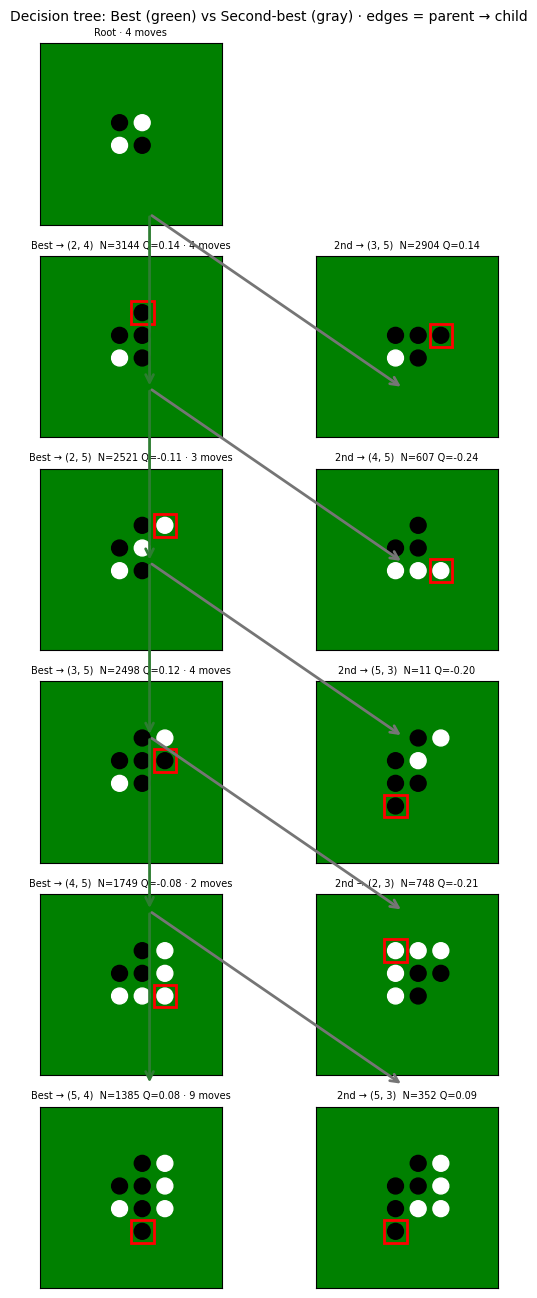

In [74]:
# Tree visualizer: parent–child layout with move counts and edges
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
import matplotlib.transforms as mtrans
from alphazero.games.othello import OthelloBoard

def draw_othello_board(ax, grid, n, highlight_cell=None, title="", small=True):
    """Draw Othello board on ax. small=True for compact tree nodes."""
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)
    ax.set_aspect("equal")
    r = 0.35 if small else 0.4
    ax.add_patch(patches.Rectangle((0, 0), n, n, color=OthelloBoard.COLORS[0]))
    for row in range(n):
        for col in range(n):
            if grid[row, col] != 0:
                ax.add_patch(patches.Circle(
                    xy=(col + 0.5, n - row - 0.5), radius=r,
                    color=OthelloBoard.COLORS[grid[row, col]], zorder=1,
                ))
            if highlight_cell == (row, col):
                ax.add_patch(patches.Rectangle(
                    (col, n - row - 1), 1, 1,
                    fill=False, edgecolor="red", linewidth=2, zorder=2,
                ))
    ax.grid(True, color="black", linewidth=0.5)
    if title:
        ax.set_title(title, fontsize=7 if small else 9)
    ax.set_xticks([])
    ax.set_yticks([])

def visualize_decision_tree(decisions, n, max_depths=None):
    """
    Tree layout: root at top; each node has two children (best = chosen, 2nd = rejected).
    Edges show parent→child. Each node shows board + "N moves" at that depth.
    """
    steps = decisions if max_depths is None else decisions[:max_depths]
    D = len(steps)
    if D == 0:
        return
    # Rows: 0 = root, 1..D = children at depth 1..D (best left, second right)
    n_rows = D + 1
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 2.2 * n_rows))
    for r in range(n_rows):
        for c in range(n_cols):
            axes[r, c].set_visible(False)

    # Row 0: root
    step0 = steps[0]
    root_ax = axes[0, 0]
    root_ax.set_visible(True)
    n_ch0 = step0.get("n_children", "?")
    draw_othello_board(
        root_ax, step0["grid"], n,
        title=f"Root · {n_ch0} moves",
        small=True,
    )
    root_ax.set_facecolor("#e3f2fd")

    # Rows 1..D: at depth i, step i gives best and second-best children
    for i, step in enumerate(steps):
        grid = step["grid"]
        player = step["player"]
        best_move = step["best_move"]
        second_move = step.get("second_best_move")
        best_N, best_Q = step["best_N"], step["best_Q"]
        second_N = step.get("second_best_N")
        second_Q = step.get("second_best_Q")
        n_ch = step.get("n_children", "?")

        board = OthelloBoard(n=n, grid=grid.copy(), player=player)
        board_best = board.clone()
        board_best.play_move(best_move)

        ax_best = axes[i + 1, 0]
        ax_second = axes[i + 1, 1]
        ax_best.set_visible(True)
        ax_best.set_facecolor("#e8f5e9")
        draw_othello_board(
            ax_best, board_best.grid, n, highlight_cell=best_move, small=True,
            title=f"Best → {best_move}  N={best_N:.0f} Q={best_Q:.2f} · {n_ch} moves",
        )
        if second_move is not None and second_N is not None:
            board_second = board.clone()
            board_second.play_move(second_move)
            ax_second.set_visible(True)
            ax_second.set_facecolor("#fff3e0")
            draw_othello_board(
                ax_second, board_second.grid, n, highlight_cell=second_move, small=True,
                title=f"2nd → {second_move}  N={second_N:.0f} Q={second_Q:.2f}",
            )
        else:
            ax_second.set_visible(True)
            ax_second.set_facecolor("#f5f5f5")
            ax_second.text(n/2, n/2, "—", ha="center", va="center", fontsize=12)
            ax_second.set_title("2nd — (none)")
            ax_second.set_xlim(0, n)
            ax_second.set_ylim(0, n)
            ax_second.set_xticks([])
            ax_second.set_yticks([])

    # Edges: row i, col 0 (parent) → row i+1, col 0 (best) and row i+1, col 1 (second)
    def ax_center(ax):
        b = ax.get_position()
        return (b.x0 + b.width / 2, b.y0 + b.height / 2)
    for i in range(D):
        parent_ax = axes[i, 0]
        for j, child_ax in enumerate([axes[i + 1, 0], axes[i + 1, 1]]):
            if not child_ax.get_visible():
                continue
            arrow = FancyArrowPatch(
                ax_center(parent_ax), ax_center(child_ax),
                transform=fig.transFigure,
                arrowstyle="->", mutation_scale=14, linewidth=2,
                color="#2e7d32" if j == 0 else "#757575",
            )
            fig.patches.append(arrow)
    plt.suptitle("Decision tree: Best (green) vs Second-best (gray) · edges = parent → child", fontsize=10)
    plt.tight_layout()
    plt.show()

# Show first 5 depths (use max_depths=None for full path)
visualize_decision_tree(decisions, n=board_snapshot.n, max_depths=5)

# VIZ

In [ ]:
def get_full_decision_tree_recursive(mct, board, max_depth, sort_key="N"):
    """
    Builds a 'spine' tree:
    - Main path (best moves) spawns second-best alternatives at each level
    - Second-best branches only follow their own best moves (no further branching)
    """
    from alphazero.games.othello import OthelloBoard
    n = board.n
    levels = [[] for _ in range(max_depth + 1)]
    
    def walk(node, board_state, depth, label, move, idx, is_main_path):
        if depth > max_depth:
            return
        
        # Ensure list is long enough
        while len(levels[depth]) <= idx:
            levels[depth].append(None)
        
        levels[depth][idx] = {
            "grid": board_state.grid.copy(),
            "player": board_state.player,
            "move": move,
            "label": label,
            "n_children": len(node.children),
            "N": getattr(node, 'N', None),
            "Q": getattr(node, 'Q', None),
            "_mct_node": node,
            # pull the activations from the net here . I woudl think it is as simple as feeding in the position and getting the net back? but then how do I get multiple activations to compare with 
            "activations": 
        }
        
        if not node.children:
            return
            
        items = sorted(node.children.items(), 
                      key=lambda x: getattr(x[1], sort_key), reverse=True)
        
        # Best child - always follow it
        best_move, best_node = items[0]
        b_best = board_state.clone()
        b_best.play_move(best_move)
        walk(best_node, b_best, depth + 1, "best", best_move, 2 * idx, is_main_path)
        
        # Second-best child - ONLY if we're on the main path
        if len(items) >= 2 and is_main_path:
            second_move, second_node = items[1]
            b_second = board_state.clone()
            b_second.play_move(second_move)
            # Pass is_main_path=False so this branch won't spawn more second-bests
            walk(second_node, b_second, depth + 1, "2nd", second_move, 2 * idx + 1, False)
    
    walk(mct.root, board.clone(), 0, "root", None, 0, True)
    return levels

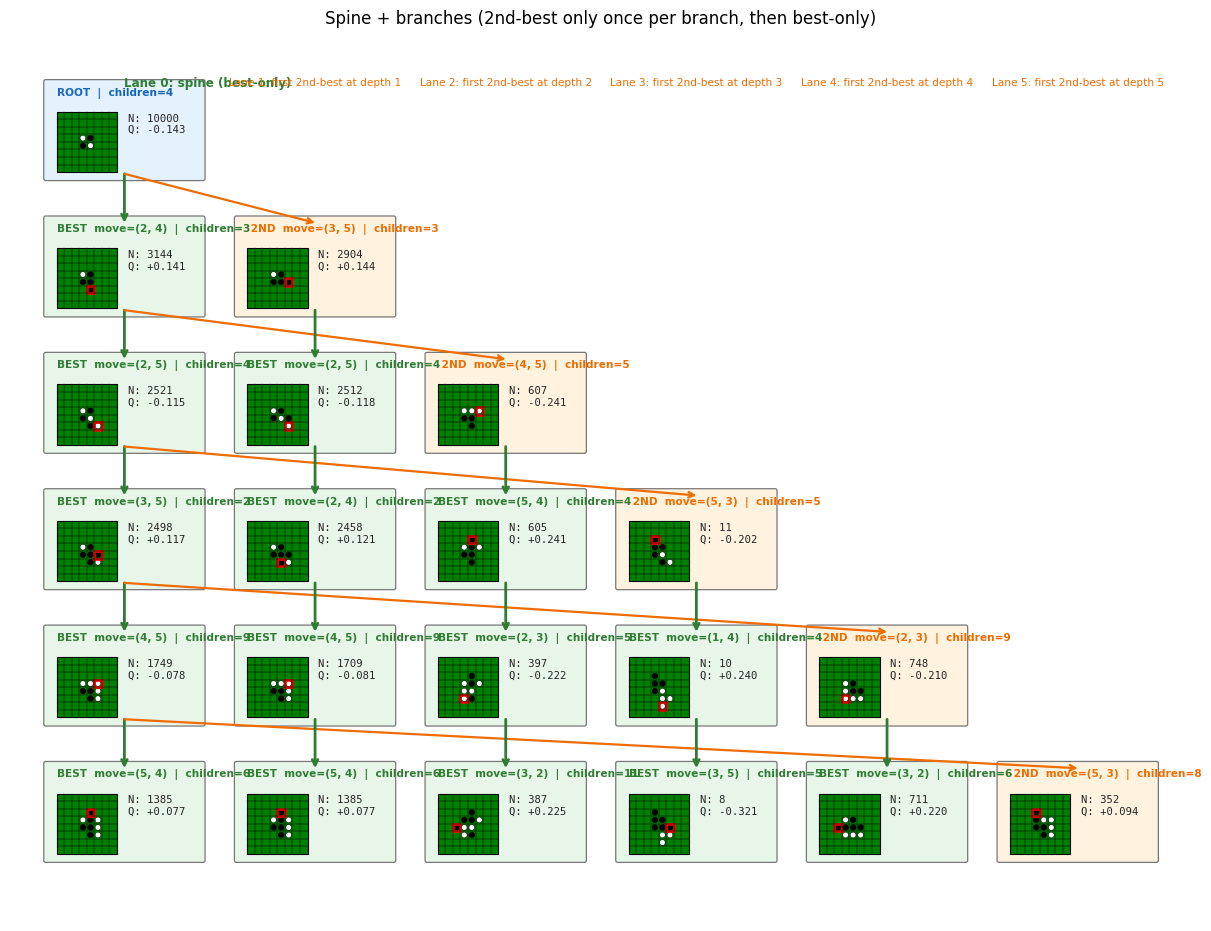

In [78]:
def visualize_spine_decision_tree(levels, n, board_scale=1.0):
    """
    Spine + branches visualization that scales to larger max_depth.

    Layout idea:
    - Lane 0: the main (all-left / best-only) spine.
    - Lane k (k>=1): nodes whose FIRST right-turn (second-best) occurs at depth k.
      (Computed from idx's binary path bits for that depth.)
    - This keeps width O(max_depth) rather than O(2^max_depth).

    Assumes heap-style indexing:
      parent (d, idx) -> children (d+1, 2*idx) [best/left], (d+1, 2*idx+1) [second/right]
    """

    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from alphazero.games.othello import OthelloBoard

    max_depth = len(levels) - 1

    # ---- Collect nodes ----
    node_positions = {}
    for d, level in enumerate(levels):
        for idx, info in enumerate(level):
            if info is not None:
                node_positions[(d, idx)] = info

    if not node_positions:
        print("No nodes to visualize.")
        return

    # ---- Lane assignment ----
    # lane = 0 if path bits are all 0; else lane = position (1..d) of first '1' in MSB->LSB path bits.
    def lane_for(d, idx):
        if d == 0:
            return 0
        # idx in [0, 2^d). Represent with d bits.
        bits = f"{idx:0{d}b}"  # MSB first
        first_one = bits.find("1")
        return 0 if first_one == -1 else (first_one + 1)  # +1 => lanes 1..d

    lane = {(d, idx): lane_for(d, idx) for (d, idx) in node_positions.keys()}
    max_lane = max(lane.values())  # <= max_depth

    # ---- Layout parameters (tuned to scale) ----
    # Board "card" dimensions in *data coords*
    board_size = 1.0 * board_scale
    meta_w = 1.25 * board_scale          # width of metadata panel
    pad = 0.18 * board_scale             # padding around board/meta inside card
    card_w = board_size + meta_w + 2 * pad
    card_h = board_size + 2 * pad + 0.25 * board_scale   # extra top space for title line

    lane_gap = 0.55 * board_scale        # gap between lanes
    depth_gap = 0.65 * board_scale       # gap between rows
    x_step = card_w + lane_gap
    y_step = card_h + depth_gap

    # ---- Compute node centers (x,y) ----
    # Put depth 0 at top => y increases downward, then invert axis at end (or compute reversed).
    xy = {}
    for (d, idx) in node_positions.keys():
        L = lane[(d, idx)]
        cx = L * x_step
        cy = d * y_step
        xy[(d, idx)] = (cx, cy)

    # ---- Figure sizing ----
    # Convert data coords -> inches roughly: we pick figsize based on number of lanes / depth.
    fig_w = max(8, (max_lane + 1) * (2.2 * board_scale))
    fig_h = max(8, (max_depth + 1) * (1.75 * board_scale))

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.set_xlim(-x_step * 0.6, (max_lane + 1) * x_step - x_step * 0.4)
    ax.set_ylim(-y_step * 0.6, (max_depth + 1) * y_step - y_step * 0.2)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.invert_yaxis()  # depth 0 at top

    # ---- Drawing helpers ----
    def draw_card(cx, cy, info, is_root=False):
        grid = info["grid"]
        move = info["move"]
        label = info["label"]
        n_ch = info["n_children"]
        N = info.get("N")
        Q = info.get("Q")

        # Colors
        if is_root:
            bg = "#e3f2fd"
            accent = "#1565c0"
        elif label == "best":
            bg = "#e8f5e9"
            accent = "#2e7d32"
        else:
            bg = "#fff3e0"
            accent = "#ef6c00"

        # Card origin
        left = cx - card_w / 2
        top = cy - card_h / 2

        # Card box
        card = patches.FancyBboxPatch(
            (left, top),
            card_w, card_h,
            boxstyle="round,pad=0.03",
            facecolor=bg, edgecolor="#777777", linewidth=0.9
        )
        ax.add_patch(card)

        # Title line (top-left inside card)
        if is_root:
            title = f"ROOT  |  children={n_ch}"
        else:
            title = f"{label.upper():>4}  move={move}  |  children={n_ch}"
        ax.text(
            left + pad, top + 0.18 * board_scale,
            title,
            ha="left", va="center",
            fontsize=8 * board_scale, fontweight="bold", color=accent
        )

        # Board region
        board_left = left + pad
        board_top = top + 0.32 * board_scale + pad
        board_bottom = board_top
        # board rectangle (we draw from top-left using bottom coords)
        board_y = board_top
        board_x = board_left

        # Board background
        ax.add_patch(
            patches.Rectangle(
                (board_x, board_y),
                board_size, board_size,
                facecolor=OthelloBoard.COLORS[0], edgecolor="black", linewidth=0.8
            )
        )

        # Grid lines
        cell = board_size / n
        for i in range(1, n):
            ax.plot([board_x + i * cell, board_x + i * cell], [board_y, board_y + board_size], "k-", lw=0.35)
            ax.plot([board_x, board_x + board_size], [board_y + i * cell, board_y + i * cell], "k-", lw=0.35)

        # Pieces + highlight
        r = cell * 0.38
        for row in range(n):
            for col in range(n):
                v = grid[row, col]
                if v != 0:
                    px = board_x + col * cell + cell / 2
                    py = board_y + (n - 1 - row) * cell + cell / 2
                    ax.add_patch(
                        patches.Circle((px, py), r,
                                       facecolor=OthelloBoard.COLORS[v],
                                       edgecolor="black", linewidth=0.35)
                    )
                if move == (row, col):
                    hx = board_x + col * cell
                    hy = board_y + (n - 1 - row) * cell
                    ax.add_patch(
                        patches.Rectangle((hx, hy), cell, cell,
                                          fill=False, edgecolor="red", linewidth=1.8)
                    )

        # Metadata panel (right side)
        meta_left = board_x + board_size + pad
        meta_top = board_y + 0.02 * board_scale

        # Nicely formatted stats (monospace so it lines up)
        lines = []
        if N is not None:
            lines.append(f"N: {N:.0f}")
        if Q is not None:
            lines.append(f"Q: {Q:+.3f}")
        # Add more fields if present
        if "P" in info:
            lines.append(f"P: {info['P']:.3f}")
        if "U" in info:
            lines.append(f"U: {info['U']:.3f}")

        meta_text = "\n".join(lines) if lines else "(no stats)"
        ax.text(
            meta_left, meta_top,
            meta_text,
            ha="left", va="top",
            fontsize=8 * board_scale,
            family="monospace",
            color="#222222"
        )

    def draw_arrow(p_xy, c_xy, is_best):
        # Slightly offset arrow to reduce overlap with cards
        (px, py) = p_xy
        (cx, cy) = c_xy

        # Arrow from bottom center of parent card to top center of child card
        start = (px, py + card_h * 0.45)
        end = (cx, cy - card_h * 0.45)

        color = "#2e7d32" if is_best else "#ef6c00"
        lw = 2.0 if is_best else 1.6

        ax.annotate(
            "", xy=end, xytext=start,
            arrowprops=dict(arrowstyle="->", color=color, lw=lw, shrinkA=0, shrinkB=0)
        )

    # ---- Draw edges first (so cards sit on top) ----
    for (d, idx), info in node_positions.items():
        if d >= max_depth:
            continue
        parent = (d, idx)
        for k, child_idx in enumerate([2 * idx, 2 * idx + 1]):
            child = (d + 1, child_idx)
            if child not in node_positions:
                continue
            # k==0 => best/left, k==1 => second/right
            draw_arrow(xy[parent], xy[child], is_best=(k == 0))

    # ---- Draw nodes ----
    for (d, idx), info in node_positions.items():
        cx, cy = xy[(d, idx)]
        draw_card(cx, cy, info, is_root=(d == 0))

    # ---- Lane labels (helpful when depth gets big) ----
    ax.text(0, -0.35 * y_step, "Lane 0: spine (best-only)", ha="left", va="center",
            fontsize=9 * board_scale, color="#2e7d32", fontweight="bold")
    for L in range(1, max_lane + 1):
        ax.text(L * x_step, -0.35 * y_step, f"Lane {L}: first 2nd-best at depth {L}",
                ha="center", va="center", fontsize=8 * board_scale, color="#ef6c00")

    plt.title("Spine + branches (2nd-best only once per branch, then best-only)", fontsize=12, pad=18)
    plt.tight_layout()
    plt.show()

full_tree_max_depth = 5  # try bigger
full_levels = get_full_decision_tree_recursive(mct, board_snapshot, max_depth=full_tree_max_depth)
visualize_spine_decision_tree(full_levels, board_snapshot.n, board_scale=0.95)

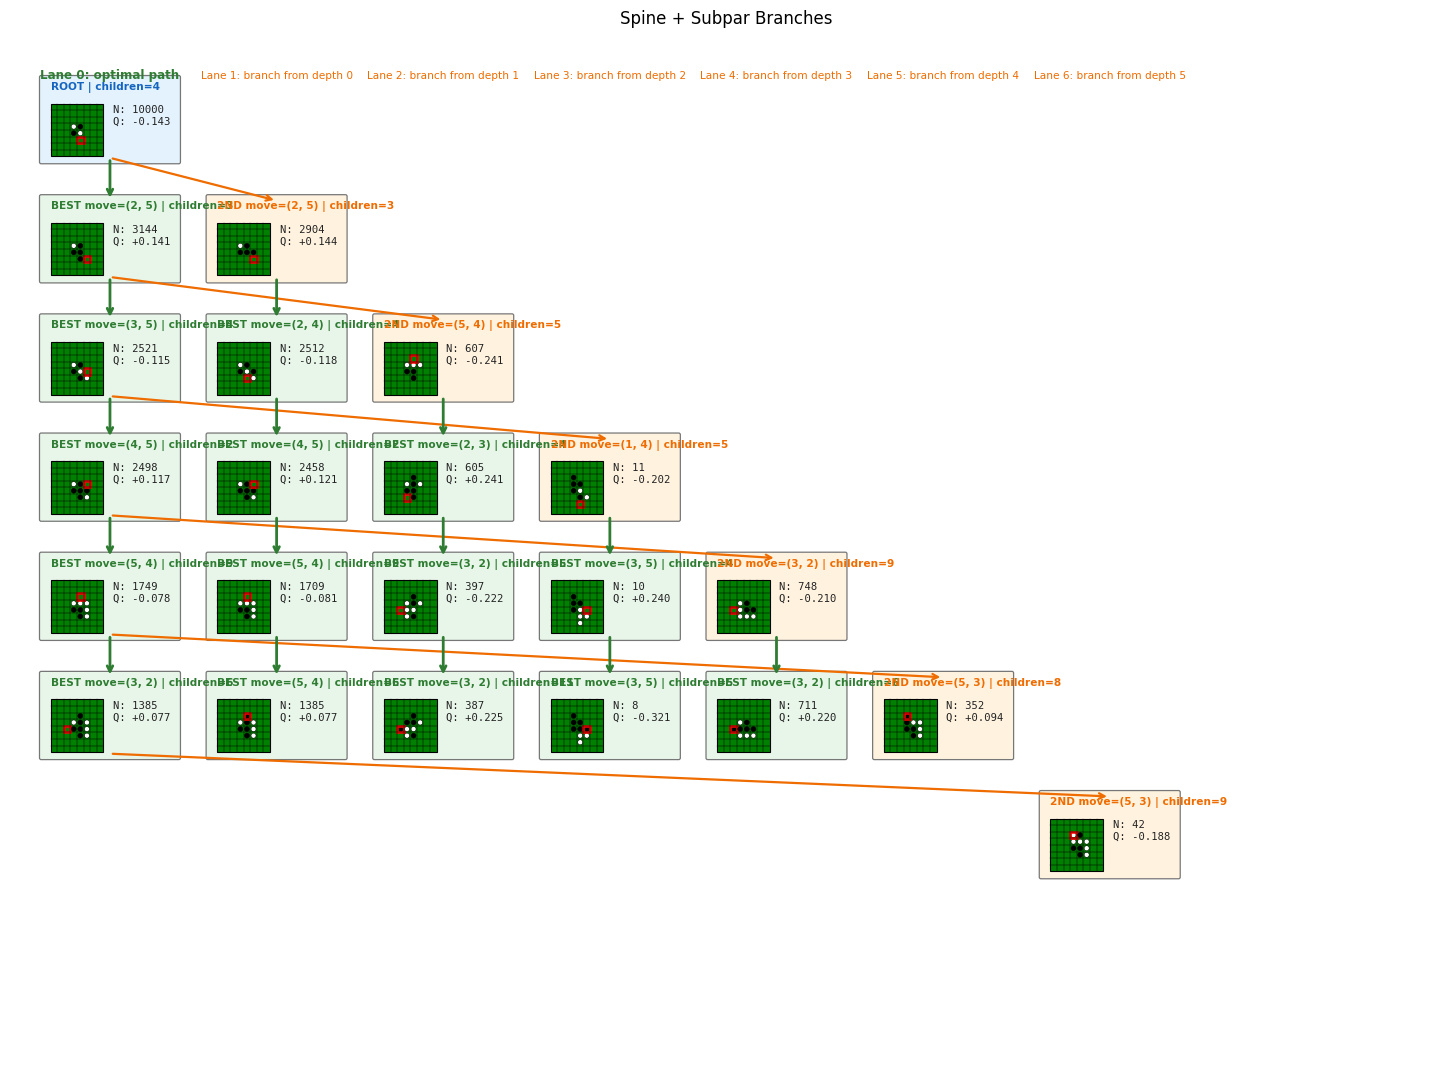

In [ ]:
from src.hooks.extract import get_single_activation
def get_spine_tree(mct, board, net, layer_name, max_depth, sort_key="N"):
    """
    Builds a spine tree with clean data structure:
    
    Returns:
        {
            "optimal_path": [node_info_0, node_info_1, ...],  # Main spine
            "subpar_branches": {
                branch_depth: [node_info_0, node_info_1, ...],  # Branch starting at this depth
                ...
            }
        }
    
    Each node_info contains:
        - grid, player, move, label
        - N, Q
        - activation
        - depth (global depth in tree)
    """
    
    def make_node_info(board_state, node, move, label, depth):
        activation = get_single_activation(
            net,
            board_state.grid,
            board_state.player,
            layer_name
        )
        return {
            "grid": board_state.grid.copy(),
            "player": board_state.player,
            "move": move,
            "label": label,
            "depth": depth,
            "n_children": len(node.children) if node.children else 0,
            "N": getattr(node, 'N', None),
            "Q": getattr(node, 'Q', None),
            "activation": activation,
        }
    
    # def follow_best_path(start_node, start_board, start_depth, max_d):
    #     """Follow best moves from a starting point."""
    #     path = []
    #     current_node = start_node
    #     current_board = start_board.clone()
        
    #     for d in range(start_depth, max_d + 1):
    #         if d == start_depth:
    #             # First node in path
    #             label = "2nd" if start_depth > 0 else "root"
    #         else:
    #             label = "best"
            
    #         path.append(make_node_info(current_board, current_node, 
    #                                    current_board.last_move if hasattr(current_board, 'last_move') else None,
    #                                    label, d))
            
    #         if not current_node.children:
    #             break
            
    #         items = sorted(current_node.children.items(),
    #                       key=lambda x: getattr(x[1], sort_key), reverse=True)
            
    #         best_move, best_node = items[0]
    #         current_board = current_board.clone()
    #         current_board.play_move(best_move)
    #         path[-1]["move"] = best_move  # Store the move that leads to next
    #         current_node = best_node
        
    #     return path
    
    # Build optimal path (spine)
    optimal_path = []
    subpar_branches = {}
    
    current_node = mct.root
    current_board = board.clone()
    
    for d in range(max_depth + 1):
        # Record this node on optimal path
        move_taken = None
        label = "root" if d == 0 else "best"
        
        node_info = make_node_info(current_board, current_node, move_taken, label, d)
        optimal_path.append(node_info)
        
        if not current_node.children:
            break
        
        items = sorted(current_node.children.items(),
                      key=lambda x: getattr(x[1], sort_key), reverse=True)
        
        # Record the move we're about to take
        best_move, best_node = items[0]
        optimal_path[-1]["move"] = best_move
        
        # Spawn subpar branch if second-best exists
        if len(items) >= 2:
            second_move, second_node = items[1]
            
            # Create branch starting board
            branch_board = current_board.clone()
            branch_board.play_move(second_move)
            
            # Follow best path from this branch point
            branch_path = []
            
            # First node of branch
            first_node_info = make_node_info(branch_board, second_node, second_move, "2nd", d + 1)
            branch_path.append(first_node_info)
            
            # Continue following best from here
            if second_node.children:
                branch_items = sorted(second_node.children.items(),
                                     key=lambda x: getattr(x[1], sort_key), reverse=True)
                
                branch_current_node = second_node
                branch_current_board = branch_board.clone()
                
                for bd in range(d + 2, max_depth + 1):
                    if not branch_current_node.children:
                        break
                    
                    branch_items = sorted(branch_current_node.children.items(),
                                         key=lambda x: getattr(x[1], sort_key), reverse=True)
                    
                    b_move, b_node = branch_items[0]
                    branch_path[-1]["move"] = b_move
                    
                    branch_current_board = branch_current_board.clone()
                    branch_current_board.play_move(b_move)
                    branch_current_node = b_node
                    
                    branch_path.append(make_node_info(branch_current_board, branch_current_node, 
                                                      b_move, "best", bd))
            
            subpar_branches[d] = branch_path
        
        # Move to next on optimal path
        current_board = current_board.clone()
        current_board.play_move(best_move)
        current_node = best_node
    
    return {
        "optimal_path": optimal_path,
        "subpar_branches": subpar_branches,
    }


def build_constraint_pairs(tree_data, single_player=False):
    """
    Build (z_plus, z_minus) pairs from the tree structure.
    
    For each subpar branch starting at depth j:
        Compare optimal_path[t] vs subpar_branch[t - j - 1] for aligned depths
    """
    optimal_path = tree_data["optimal_path"]
    subpar_branches = tree_data["subpar_branches"]
    
    pairs = []
    
    for branch_depth_j, branch_path in subpar_branches.items():
        # branch_path[0] is at global depth (branch_depth_j + 1)
        # branch_path[k] is at global depth (branch_depth_j + 1 + k)
        
        for k, branch_node in enumerate(branch_path):
            global_depth_t = branch_depth_j + 1 + k
            
            # Skip if single_player and wrong parity
            if single_player and global_depth_t % 2 == 1:
                continue
            
            # Get corresponding optimal path node
            if global_depth_t >= len(optimal_path):
                break
            
            z_plus = optimal_path[global_depth_t]["activation"]
            z_minus = branch_node["activation"]
            
            pairs.append((z_plus, z_minus))
    
    return pairs


def find_concept_vector(pairs):
    """
    Solve: min ||v||_1  s.t. v · z_plus >= v · z_minus for all pairs
    """
    import cvxpy as cp
    
    if not pairs:
        raise ValueError("No constraint pairs")
    
    dim = pairs[0][0].shape[0]
    v = cp.Variable(dim)
    
    constraints = [v @ z_plus >= v @ z_minus for z_plus, z_minus in pairs]
    
    problem = cp.Problem(cp.Minimize(cp.norm(v, 1)), constraints)
    problem.solve()
    
    if problem.status not in ["optimal", "optimal_inaccurate"]:
        print(f"Warning: {problem.status}")
    
    return v.value


def discover_concept(mct, board, net, layer_name, max_depth=10, single_player=False):
    """Full pipeline: one position -> one concept vector."""
    tree_data = get_spine_tree(mct, board, net, layer_name, max_depth)
    pairs = build_constraint_pairs(tree_data, single_player)
    
    if not pairs:
        return None
    
    return find_concept_vector(pairs)


# ============ VISUALIZATION ============

def visualize_spine_tree(tree_data, n, board_scale=1.0):
    """
    Visualize the cleaner tree structure.
    
    Layout:
        - Lane 0: optimal path (spine)
        - Lane k: subpar branch that started at depth (k-1)
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from alphazero.games.othello import OthelloBoard
    
    optimal_path = tree_data["optimal_path"]
    subpar_branches = tree_data["subpar_branches"]
    
    max_depth = max(
        len(optimal_path) - 1,
        max((j + len(branch)) for j, branch in subpar_branches.items()) if subpar_branches else 0
    )
    
    # Lane assignment: optimal = 0, branch starting at j -> lane (j + 1)
    max_lane = max(subpar_branches.keys()) + 1 if subpar_branches else 0
    
    # Layout parameters
    board_size = 1.0 * board_scale
    meta_w = 1.25 * board_scale
    pad = 0.18 * board_scale
    card_w = board_size + meta_w + 2 * pad
    card_h = board_size + 2 * pad + 0.25 * board_scale
    
    lane_gap = 0.55 * board_scale
    depth_gap = 0.65 * board_scale
    x_step = card_w + lane_gap
    y_step = card_h + depth_gap
    
    # Collect all nodes with positions
    # (lane, depth) -> node_info
    node_positions = {}
    
    # Optimal path -> lane 0
    for node_info in optimal_path:
        d = node_info["depth"]
        node_positions[(0, d)] = node_info
    
    # Subpar branches -> lane (j + 1)
    for branch_j, branch_path in subpar_branches.items():
        lane = branch_j + 1
        for k, node_info in enumerate(branch_path):
            d = branch_j + 1 + k
            node_positions[(lane, d)] = node_info
    
    # Compute xy coordinates
    xy = {}
    for (lane, d), info in node_positions.items():
        cx = lane * x_step
        cy = d * y_step
        xy[(lane, d)] = (cx, cy)
    
    # Figure setup
    fig_w = max(8, (max_lane + 1) * (2.2 * board_scale))
    fig_h = max(8, (max_depth + 2) * (1.75 * board_scale))
    
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.set_xlim(-x_step * 0.6, (max_lane + 2) * x_step)
    ax.set_ylim(-y_step * 0.6, (max_depth + 2) * y_step)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.invert_yaxis()
    
    def draw_card(cx, cy, info):
        grid = info["grid"]
        move = info["move"]
        label = info["label"]
        n_ch = info["n_children"]
        N = info.get("N")
        Q = info.get("Q")
        depth = info["depth"]
        
        is_root = (label == "root")
        
        if is_root:
            bg, accent = "#e3f2fd", "#1565c0"
        elif label == "best":
            bg, accent = "#e8f5e9", "#2e7d32"
        else:  # 2nd
            bg, accent = "#fff3e0", "#ef6c00"
        
        left = cx - card_w / 2
        top = cy - card_h / 2
        
        card = patches.FancyBboxPatch(
            (left, top), card_w, card_h,
            boxstyle="round,pad=0.03",
            facecolor=bg, edgecolor="#777777", linewidth=0.9
        )
        ax.add_patch(card)
        
        if is_root:
            title = f"ROOT | children={n_ch}"
        else:
            title = f"{label.upper()} move={move} | children={n_ch}"
        
        ax.text(left + pad, top + 0.18 * board_scale, title,
                ha="left", va="center", fontsize=8 * board_scale,
                fontweight="bold", color=accent)
        
        # Draw board
        board_x = left + pad
        board_y = top + 0.32 * board_scale + pad
        
        ax.add_patch(patches.Rectangle(
            (board_x, board_y), board_size, board_size,
            facecolor=OthelloBoard.COLORS[0], edgecolor="black", linewidth=0.8
        ))
        
        cell = board_size / n
        for i in range(1, n):
            ax.plot([board_x + i * cell, board_x + i * cell],
                   [board_y, board_y + board_size], "k-", lw=0.35)
            ax.plot([board_x, board_x + board_size],
                   [board_y + i * cell, board_y + i * cell], "k-", lw=0.35)
        
        r = cell * 0.38
        for row in range(n):
            for col in range(n):
                v = grid[row, col]
                if v != 0:
                    px = board_x + col * cell + cell / 2
                    py = board_y + (n - 1 - row) * cell + cell / 2
                    ax.add_patch(patches.Circle(
                        (px, py), r,
                        facecolor=OthelloBoard.COLORS[v],
                        edgecolor="black", linewidth=0.35
                    ))
                if move == (row, col):
                    hx = board_x + col * cell
                    hy = board_y + (n - 1 - row) * cell
                    ax.add_patch(patches.Rectangle(
                        (hx, hy), cell, cell,
                        fill=False, edgecolor="red", linewidth=1.8
                    ))
        
        # Metadata
        meta_left = board_x + board_size + pad
        meta_top = board_y + 0.02 * board_scale
        lines = []
        if N is not None:
            lines.append(f"N: {N:.0f}")
        if Q is not None:
            lines.append(f"Q: {Q:+.3f}")
        ax.text(meta_left, meta_top, "\n".join(lines) or "(no stats)",
                ha="left", va="top", fontsize=8 * board_scale,
                family="monospace", color="#222222")
    
    def draw_arrow(start_xy, end_xy, is_best, is_branch_start=False):
        color = "#ef6c00" if is_branch_start else ("#2e7d32" if is_best else "#ef6c00")
        lw = 2.0 if is_best else 1.6
        
        sx, sy = start_xy
        ex, ey = end_xy
        
        start = (sx, sy + card_h * 0.45)
        end = (ex, ey - card_h * 0.45)
        
        ax.annotate("", xy=end, xytext=start,
                   arrowprops=dict(arrowstyle="->", color=color, lw=lw))
    
    # Draw edges
    # Optimal path edges
    for i in range(len(optimal_path) - 1):
        d = optimal_path[i]["depth"]
        if (0, d) in xy and (0, d + 1) in xy:
            draw_arrow(xy[(0, d)], xy[(0, d + 1)], is_best=True)
    
    # Branch start edges (from optimal to branch)
    for branch_j in subpar_branches.keys():
        if (0, branch_j) in xy and (branch_j + 1, branch_j + 1) in xy:
            draw_arrow(xy[(0, branch_j)], xy[(branch_j + 1, branch_j + 1)], 
                      is_best=False, is_branch_start=True)
    
    # Branch internal edges
    for branch_j, branch_path in subpar_branches.items():
        lane = branch_j + 1
        for k in range(len(branch_path) - 1):
            d = branch_j + 1 + k
            if (lane, d) in xy and (lane, d + 1) in xy:
                draw_arrow(xy[(lane, d)], xy[(lane, d + 1)], is_best=True)
    
    # Draw nodes
    for (lane, d), info in node_positions.items():
        draw_card(xy[(lane, d)][0], xy[(lane, d)][1], info)
    
    # Lane labels
    ax.text(0, -0.35 * y_step, "Lane 0: optimal path",
            ha="center", fontsize=9 * board_scale, color="#2e7d32", fontweight="bold")
    for j in subpar_branches.keys():
        ax.text((j + 1) * x_step, -0.35 * y_step, f"Lane {j+1}: branch from depth {j}",
                ha="center", fontsize=8 * board_scale, color="#ef6c00")
    
    plt.title("Spine + Subpar Branches", fontsize=12, pad=18)
    plt.tight_layout()
    plt.show()


# ============ USAGE ============

# Build tree (with activations)
tree_data = get_spine_tree(mct, board, net, "bn2", max_depth=5)

# Visualize
visualize_spine_tree(tree_data, board.n, board_scale=0.95)
import numpy as np 
# Get concept
pairs = build_constraint_pairs(tree_data, single_player=True)
v = find_concept_vector(pairs)
np.save("concept_vector.npy", v)

array([-5.60355226e-26,  2.65399748e-13,  1.00231800e-12, ...,
       -1.80204845e-14, -2.30732795e-14, -5.60355226e-26], shape=(2048,))